In [1]:
import cv2 
import numpy as np
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image

In [2]:
local = True
note = True

In [3]:
if local:
    if note:
        data_path = 'G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avulFNSGjj0WZFQsrj/BDHansen_Local'
        # workspace_path = 'C:/Users/lucas/GoogleDrive/.shortcut-targets-by-id/1lAkgsgLg50ktk5RH220KX7aLsltKY_SP/Trabalho Jacks/skinreadermodels'
    else:  
        data_path = 'C:/Users/lucas/Documents/Area_de_Trabalho/about-skinreader/dataset/BDHansen'
        workspace_path = 'C:/Users/lucas/GoogleDrive/.shortcut-targets-by-id/1lAkgsgLg50ktk5RH220KX7aLsltKY_SP/Trabalho Jacks/skinreadermodels'
else:
    data_path = '/content/drive/MyDrive/Colab Notebooks/dataset/skinreader/BDHansen'
    workspace_path = '/content/drive/MyDrive/Colab Notebooks/skinreadermodels'

# info_path = os.path.join(workspace_path, 'info')
images_closeup_path = os.path.join(data_path, 'closeup')
metadata_path = os.path.join(data_path, 'metadados')
images_all_path = os.path.join(data_path, 'all_closeup_panoramic')
images_panoramic_path = os.path.join(data_path, 'panoramic')
save_path_dataaumented = os.path.join(data_path, 'augmented_cloaseup')

In [4]:
contours = {}

In [5]:
def fixFileName(str_ret):
    return "".join([str_ret, '.jpg'])

def load_jsonfile(json_path):
    with open(json_path,'r') as arquivo:
        paciente = arquivo.read()
        return json.loads(paciente)
    
def get_json_files():
    files = os.listdir(metadata_path)
    return [load_jsonfile(os.path.join(metadata_path, f)) for f in files if f.endswith('.json')]

def get_data(json_list):
    patient_id_list = []
    image_list_for_patient = []
    for j in json_list:
        patient_id_list.append(j['_via_settings']['project']['name'].split('/')[0])
        list_aux = []
        for key, value in j['_via_img_metadata'].items():
            regions = []
            if len(value['regions']) != 0 :
                # print(value['filename'])
                # print(value['regions'][0])
                list_aux.append((value['filename'], value['regions'][0]['region_attributes']['leprosy'], len(value['regions'])))
                for region in value['regions']:
                    regions.append([region['shape_attributes']['all_points_x'], region['shape_attributes']['all_points_y']])
                
                contours[value['filename']] = regions
        if len(list_aux) != 0: image_list_for_patient.append(list_aux) #lista de imagens e diagnóstico para cada imagem para cada paciente
    
    dados = []
    c_imagenames = os.listdir(images_closeup_path)
    a_imagenames = os.listdir(images_all_path)
    p_imagenames = os.listdir(images_panoramic_path)
    print(f'Numero de imagens -> \nColseup: {len(c_imagenames)}\nAll: {len(a_imagenames)}\nPanoramicas: {len(p_imagenames)}')
    
    for index, p in enumerate(patient_id_list):
        study_id = p.split('-')[1]

        c_images = [image_name for image_name in c_imagenames if study_id in image_name]
        a_images = [image_name for image_name in a_imagenames if study_id in image_name]
        p_images = [image_name for image_name in p_imagenames if study_id in image_name]

        for i in c_images:
            no_extention = i.split('.')[0]
            for n in image_list_for_patient[index]:
                if no_extention in n[0]:
                    dados.append([
                        study_id, 
                        p, 
                        no_extention, 
                        n[0], 
                        os.path.join(images_closeup_path, i), 
                        n[1], 
                        'all', 
                        i.split('.')[0].split('-')[-1],
                        n[2]
                        ])

    return dados

In [6]:
jsonfiles = get_json_files()
print(f'Patients Num -> {len(jsonfiles)}')
data = get_data(jsonfiles)
print(f'Imagens Num -> {len(data)}')

Patients Num -> 225
Numero de imagens -> 
Colseup: 732
All: 1231
Panoramicas: 499
Imagens Num -> 717


In [7]:
df = pd.DataFrame(data, columns=['StudyID', 'patient_id', 'image_name', 'filename', 'image_path', 'patient_leprosy', 'local_dist', 'type', 'num_regions'])
df.tail()

StudyID     patient_id                   image_name  \
712   223LO  Patient-223LO   Image-223LO4-trunk-closeup   
713   223LO  Patient-223LO   Image-223LO2-trunk-closeup   
714   223LO  Patient-223LO   Image-223LO5-trunk-closeup   
715   223LO  Patient-223LO   Image-223LO3-trunk-closeup   
716   223LO  Patient-223LO  Image-223LO6-llimbs-closeup   

                                              filename  \
712  https://patientimage.blob.core.windows.net/pro...   
713  https://patientimage.blob.core.windows.net/pro...   
714  https://patientimage.blob.core.windows.net/pro...   
715  https://patientimage.blob.core.windows.net/pro...   
716  https://patientimage.blob.core.windows.net/pro...   

                                            image_path   patient_leprosy  \
712  G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avul...  other_dermotosis   
713  G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avul...  other_dermotosis   
714  G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avul...  other_dermotosis   
715  G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avul...  other_dermotosis   
716  G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avul...  other_dermotosis   

    local_dist     type  num_regions  
712        all  closeup            1  
713        all  closeup            1  
714        all  closeup            1  
715        all  closeup            1  
716        all  closeup            1

# Testes sobre os pacientes
* Existe imagens do mesmo paciente mas com diagnósticos difetentes?
* O tipo de imagem closeup engloba: closeup e edge

In [8]:
for index, study_id in enumerate(df['StudyID'].unique()):
    list_diagnostics = df.loc[df['image_name'].str.contains(study_id), 'patient_leprosy'].values
    
    aux = list_diagnostics[0]
    cont_diff = 0
    for diagnostic in list_diagnostics:
        if diagnostic != aux:
            print(f'[ATENTION] Different Diagnostic for the same patient, considering differents images!!!\nDiagnostic list for images: {list_diagnostics}')
            cont_diff += 1
    
    if cont_diff == 0:
        print(f'[OK]Same diagnostic for all images, for the patient: {index}: {study_id}\nDiagnostic list for images: {list_diagnostics}')

[OK]Same diagnostic for all images, for the patient: 0: 004MF
Diagnostic list for images: ['other_dermotosis']
[OK]Same diagnostic for all images, for the patient: 1: 006CJ
Diagnostic list for images: ['leprosy' 'leprosy']
[OK]Same diagnostic for all images, for the patient: 2: 002IR
Diagnostic list for images: ['leprosy']
[OK]Same diagnostic for all images, for the patient: 3: 008JS
Diagnostic list for images: ['leprosy' 'leprosy' 'leprosy']
[OK]Same diagnostic for all images, for the patient: 4: 001WN
Diagnostic list for images: ['leprosy' 'leprosy']
[OK]Same diagnostic for all images, for the patient: 5: 007GB
Diagnostic list for images: ['other_dermotosis']
[OK]Same diagnostic for all images, for the patient: 6: 003AL
Diagnostic list for images: ['leprosy']
[OK]Same diagnostic for all images, for the patient: 7: 005MO
Diagnostic list for images: ['other_dermotosis']
[OK]Same diagnostic for all images, for the patient: 8: 015AC
Diagnostic list for images: ['leprosy']
[OK]Same diagno

In [9]:
df_closeup = df.loc[df['type'] != 'panoramic']
df_closeup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 716
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   StudyID          717 non-null    object
 1   patient_id       717 non-null    object
 2   image_name       717 non-null    object
 3   filename         717 non-null    object
 4   image_path       717 non-null    object
 5   patient_leprosy  717 non-null    object
 6   local_dist       717 non-null    object
 7   type             717 non-null    object
 8   num_regions      717 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 56.0+ KB


# Teste com imagem escolhida randomicamente

In [27]:
df_of_interest = df.loc[df['num_regions'] >= 3]

In [57]:
indx = df_of_interest.index[random.randint(0, len(df_of_interest.index))]
# indx = df_of_interest.loc[df_of_interest['image_name'] == 'Image-071FP2-trunk-closeup'].index
# indx = df_of_interest.loc[df_of_interest['image_name'] == 'Image-123AS3-ulimbs-closeup'].index
print(indx)
# indx = 439

493


In [58]:
random_type_image = df_of_interest.loc[indx]['type']
random_path_image = df_of_interest.loc[indx]['image_path']
random_key = df_of_interest.loc[indx]['filename']

In [59]:
print(f'Path da imagem randomica: {random_path_image}')
print(f'Chave da imagem randomica: {random_key}')
print(f'Diagnóstico: {df_of_interest.loc[indx].patient_leprosy}')


Path da imagem randomica: G:/.shortcut-targets-by-id/13rzmaQd1P_XCr1avulFNSGjj0WZFQsrj/BDHansen_Local\closeup\Image-169RS1-ulimbs-closeup.jpg
Chave da imagem randomica: https://patientimage.blob.core.windows.net/processedimages/Patient-169RS/Image-169RS1-ulimbs-closeup.jpg
Diagnóstico: leprosy


In [60]:
random_image = cv2.imread(random_path_image)
random_image_rgb = np.copy(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))

In [61]:
# polys
isClosed = True
color_poly = (255, 0, 0)
color_ret = (0, 255, 0) 
thickness = 5
# text
# font
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 5
color_text = (0, 0, 100)
thickness = 6

image = None
image_rgb = None
roi = None
roi_rgb = None

image = random_image.copy()
image_rgb = random_image_rgb.copy()
image_text = random_image_rgb.copy()
image_to_drawn = image_text.copy()
dict_contours = {}

for index, region in enumerate(contours[random_key]):
    pts = np.array(tuple(zip(region[0], region[1])), dtype=np.int32)
    
    image = cv2.polylines(image, [pts], isClosed, color_poly, thickness)
    image_rgb = cv2.polylines(image_rgb, [pts], isClosed, color_poly, thickness)
    
    image_to_drawn = cv2.polylines(image_to_drawn, [pts], isClosed, color_poly, thickness)
    x,y,w,h = cv2.boundingRect(pts)
    roi = np.copy(image[y : y + h, x : x + w])
    roi_rgb = np.copy(image_rgb[y : y + h, x : x + w])
    
    image = cv2.rectangle(image,(x,y),(x+w,y+h),color_ret,thickness)
    image_rgb = cv2.rectangle(image_rgb,(x,y),(x+w,y+h),color_ret,thickness)
    
    text = 'reg_' + str(index)
    image_text = cv2.rectangle(image_text,(x,y),(x+w,y+h),color_ret,thickness)
    image_text = cv2.polylines(image_text, [pts], isClosed, color_poly, thickness)
    image_text = cv2.putText(image_text, text, (x, y-15), font, fontScale, color_text, thickness, cv2.LINE_AA)
   
    dict_contours[text] = [x,y,w,h]

## Plot image and regions

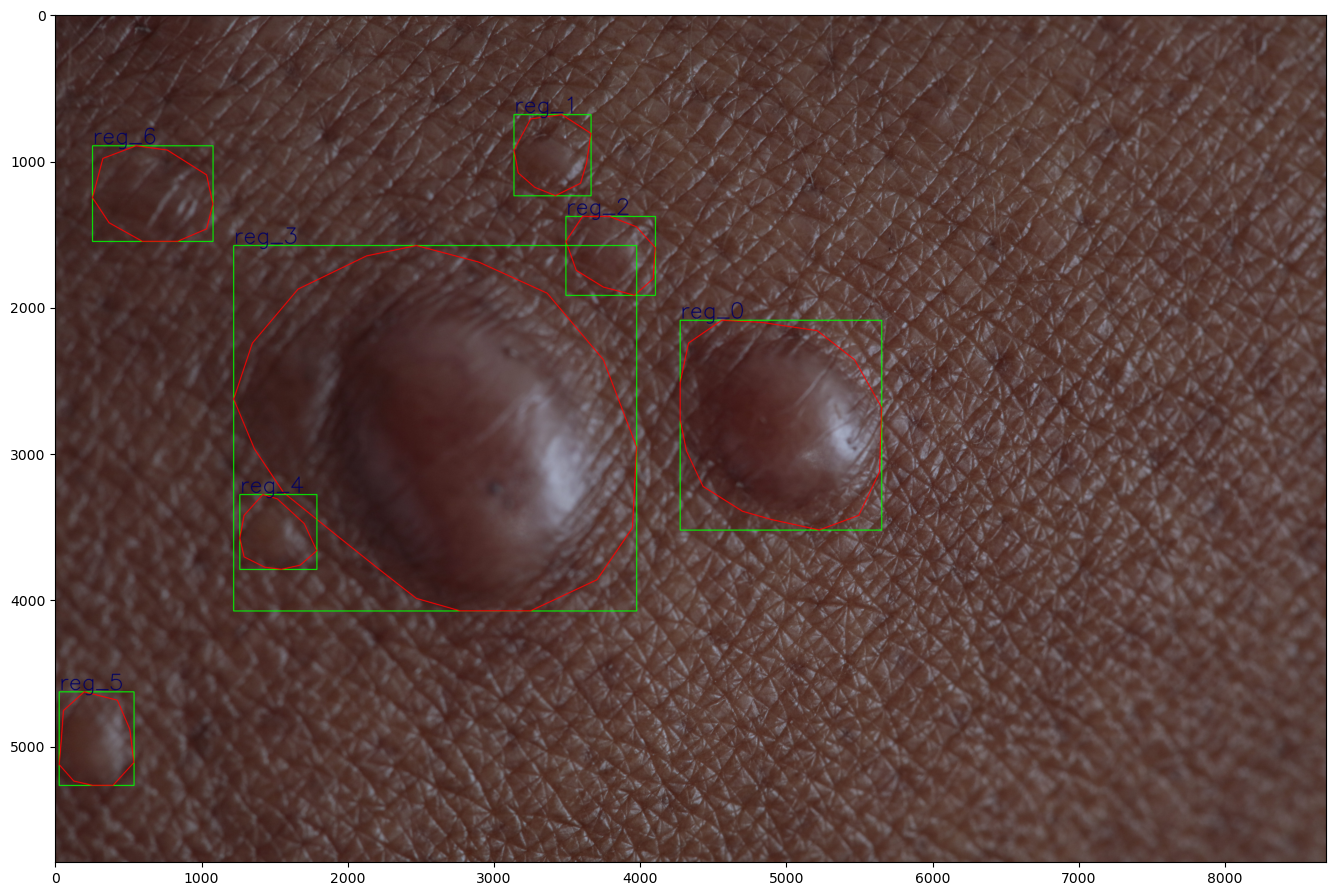

In [62]:
plt.figure(figsize=(18,11))
plt.imshow(image_text)

In [63]:

def isInside(box1, box2):
  """
    person is the dict with x1, y1, x2 and y2 for that person
    house is the dict with x1, y1, x2 and y2 for that person
  """
  
  # First we make sure we compare things in the right order
  # You can skip that part if you are sure that in all cases x1 < x2 and y1 < y2
  box1_xmin = box1[0]
  box1_xmax = box1[0] + box1[2]
  box1_ymin = box1[1]
  box1_ymax = box1[1] + box1[3]
  
  box2_xmin = box2[0]
  box2_xmax = box2[0] + box2[2]
  box2_ymin = box2[1]
  box2_ymax = box2[1] + box2[3]
  
  print(box1_xmax, box1_xmin, box1_ymax, box1_ymin)
  print(box2_xmax, box2_xmin, box2_ymax, box2_ymin)
  
  # Then you perform your checks. From what I understood,
  # you want the result to be true if any corner of the person
  # is inside the house's bounding box.
  
  # p_corners = [
  #   (box1_xmin, box1_ymin),
  #   (box1_xmin, box1_ymax),
  #   (box1_xmax, box1_ymin),
  #   (box1_xmax, box1_ymax)
  # ]

  # for corner in p_corners:
  #   in_range_along_x = corner[0] < box2_xmax and corner[0] > box2_xmin
  #   in_range_along_y = corner[1] < box2_ymax and corner[1] > box2_ymin
  #   if in_range_along_x and in_range_along_y:
  #     print('return true - corners')
  #     return True
    
  # for x in range(box1_xmin, box1_xmax + 1):
  in_range_along_y_1 = box1_ymin < box2_ymax and box1_ymin > box2_ymin
  in_range_along_y_2 = box1_ymax < box2_ymax and box1_ymax > box2_ymin
  
  in_range_along_x_1 = box1_xmin < box2_xmax and box1_xmin > box2_xmin
  in_range_along_x_2 = box1_xmax < box2_xmax and box1_xmax > box2_xmin
  
  isInside = (in_range_along_y_1 and (in_range_along_x_1 or in_range_along_x_2)) or (in_range_along_y_2 and (in_range_along_x_1 or in_range_along_x_2))
  
  print(in_range_along_x_1, in_range_along_x_2, in_range_along_y_1, in_range_along_y_2)
  
  if isInside:
    print('Box Inside')
    return True                      
  
  return False

In [64]:
print(list(dict_contours.keys()))


['reg_0', 'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5', 'reg_6']


## Pre-processing the regions

In [65]:
isClosed = True
color = (255, 0, 0)
color_ret = (0, 255, 0) 
thickness = 5

image = None
image_rgb = None
roi = None
roi_rgb = None

intersetion_contours = []
frame_intersection = []
image_gray_reference = cv2.cvtColor(random_image.copy(), cv2.COLOR_BGR2GRAY)
list_of_keys = list(dict_contours.keys())

while True:
    reiniciar = False
    found = False
    for index, key_1 in enumerate(dict_contours.keys()):
        
        if (index + 1) < len(dict_contours):
            
            for key_2 in list(dict_contours.keys())[index + 1:]:
                
                print(key_1, key_2)
                box1_in_box2 = isInside(dict_contours[key_1], dict_contours[key_2])
                box2_in_box1 = isInside(dict_contours[key_2], dict_contours[key_1])
                print('\n\n')
                
                if box1_in_box2 or box2_in_box1:
                    print(box1_in_box2, box2_in_box1)
                    print(f'region 1: {key_1}, {dict_contours[key_1]}')
                    print(f'region 2: {key_2}, {dict_contours[key_2]}') 
                    print('\n\n')
                    
                    black = np.zeros(image_gray_reference.shape, dtype='uint8')
                
                    mask_1 = cv2.rectangle(black.copy(), (dict_contours[key_1][0], dict_contours[key_1][1]), (dict_contours[key_1][0]+dict_contours[key_1][2],dict_contours[key_1][1]+dict_contours[key_1][3]), (255, 255, 255), -1)
                    mask1_area = dict_contours[key_1][2] * dict_contours[key_1][3]
                    
                    mask_2 = cv2.rectangle(black.copy(), (dict_contours[key_2][0], dict_contours[key_2][1]), (dict_contours[key_2][0]+dict_contours[key_2][2],dict_contours[key_2][1]+dict_contours[key_2][3]), (255, 255, 255), -1)
                    mask2_area = dict_contours[key_2][2] * dict_contours[key_2][3]
                    
                    intersection = cv2.bitwise_and(mask_1, mask_2)
                    
                    if intersection.any():
                        
                        intersection = np.where(intersection, 255, 0)
                        
                        intersection_contours, _ = cv2.findContours(np.uint8(intersection), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        intersection_area = cv2.contourArea(intersection_contours[0])
                        
                        # print(f'Area: {mask1_area}')
                        # print(f'Area: {mask2_area}')
                        # print(f'Area: {intersection_area}')
                        # print(f'Conta: {min(mask1_area, mask2_area) / 2}')
                        if (min(mask1_area, mask2_area) / 2) < intersection_area:
                            print('O contorno menor deve estar dentro do contorno maior!')
                            
                            newx, newy, neww, newh = cv2.boundingRect(np.array([
                                [min(dict_contours[key_1][0], dict_contours[key_2][0]), min(dict_contours[key_1][1], dict_contours[key_2][1])],
                                [min(dict_contours[key_1][0], dict_contours[key_2][0]), max(dict_contours[key_1][1] + dict_contours[key_1][3], dict_contours[key_2][1] + dict_contours[key_2][3])],
                                [max(dict_contours[key_1][0] + dict_contours[key_1][2], dict_contours[key_2][0] + dict_contours[key_2][2]), min(dict_contours[key_1][1], dict_contours[key_2][1])],
                                [max(dict_contours[key_1][0] + dict_contours[key_1][2], dict_contours[key_2][0] + dict_contours[key_2][2]), max(dict_contours[key_1][1] + dict_contours[key_1][3], dict_contours[key_2][1] + dict_contours[key_2][3])]
                                
                            ], dtype=np.int32))
                            
                            
                            del dict_contours[key_1]
                            del dict_contours[key_2]
                            
                            dict_contours[key_1+key_2] = [newx, newy, neww, newh]
                            reiniciar = True
                            found = True
                            break 
        else:
            break   
        
        if reiniciar: break
    
    if not found:
        
        break

reg_0 reg_1
5651 4273 3522 2087
3664 3137 1236 681
False False False False
3664 3137 1236 681
5651 4273 3522 2087
False False False False



reg_0 reg_2
5651 4273 3522 2087
4104 3492 1917 1377
False False False False
4104 3492 1917 1377
5651 4273 3522 2087
False False False False



reg_0 reg_3
5651 4273 3522 2087
3976 1221 4075 1576
False False True True
3976 1221 4075 1576
5651 4273 3522 2087
False False False False



reg_0 reg_4
5651 4273 3522 2087
1790 1263 3791 3279
False False False True
1790 1263 3791 3279
5651 4273 3522 2087
False False True False



reg_0 reg_5
5651 4273 3522 2087
540 28 5268 4628
False False False False
540 28 5268 4628
5651 4273 3522 2087
False False False False



reg_0 reg_6
5651 4273 3522 2087
1080 256 1548 894
False False False False
1080 256 1548 894
5651 4273 3522 2087
False False False False



reg_1 reg_2
3664 3137 1236 681
4104 3492 1917 1377
False True False False
4104 3492 1917 1377
3664 3137 1236 681
True False False False



reg_1 reg_3
3664 31

In [66]:
color_ret = (0, 0, 255) 
thickness = 5

image_to_drawn_1 = image_to_drawn.copy()
for key in dict_contours:
    image_to_drawn_1 = cv2.putText(image_to_drawn_1, key, (dict_contours[key][0], dict_contours[key][1] - 15), font, fontScale, color_text, thickness, cv2.LINE_AA)
    image_to_drawn_1 = cv2.rectangle(image_to_drawn_1, (dict_contours[key][0], dict_contours[key][1]), (dict_contours[key][0] + dict_contours[key][2], dict_contours[key][1] + dict_contours[key][3]), color_ret, thickness)
    
    center = (int(dict_contours[key][0] + (dict_contours[key][2] / 2)) , int(dict_contours[key][1] + (dict_contours[key][3] / 2)))
    image_to_drawn_1 = cv2.circle(image_to_drawn_1, center=center, radius=15, color=(0, 255, 0), thickness=-1)
    print(center)

(4962, 2804)
(3400, 958)
(284, 4948)
(668, 1221)
(2663, 2727)


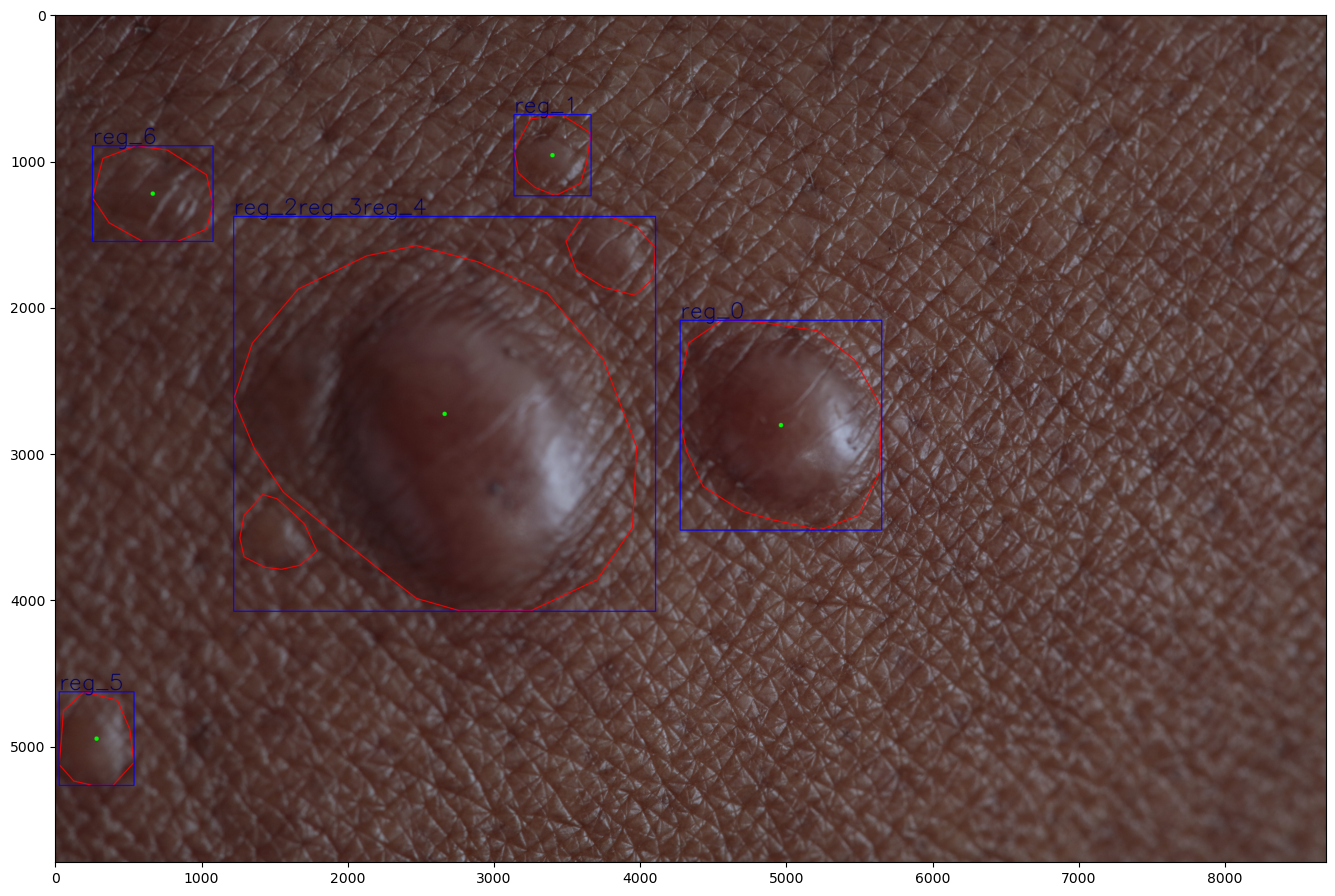

In [67]:
plt.figure(figsize=(18,11))
plt.imshow(image_to_drawn_1)

# Verficar o tamanho da região

## Inserir area no dicionario

In [68]:

while True:
    found = False
    for key in sorted(dict_contours, key = lambda region: dict_contours[region][2] * dict_contours[region][3]):
        
        if dict_contours[key][2] < 300 or dict_contours[key][3] < 300:
            print('Dimensão da região menor do que 300x300 pixels')
            
            val_min = 999999999
            chousen_reg = ''
            for key_1 in sorted(dict_contours, key = lambda region: dict_contours[region][2] * dict_contours[region][3]):
                if key_1 != key:
                    center_key_x = dict_contours[key][0] + (dict_contours[key][2] / 2)
                    center_key_y = dict_contours[key][1] + (dict_contours[key][3] / 2)
                    center_key1_x = dict_contours[key_1][0] + (dict_contours[key_1][2] / 2)
                    center_key1_y = dict_contours[key_1][1] + (dict_contours[key_1][3] / 2)
                            
                    dist =  np.sqrt((center_key_x - center_key1_x)**2 + (center_key_y - center_key1_y)**2)
                    
                    print(dist, val_min)
                    if dist < val_min:
                        # print(val, val_min)
                        val_min = dist
                        chousen_reg = key_1
            
            print(chousen_reg)
            print(dict_contours[key])
            print(dict_contours[chousen_reg])
            print('\n\n')
            
            newx, newy, neww, newh = cv2.boundingRect(np.array([
                [min(dict_contours[key][0], dict_contours[chousen_reg][0]), min(dict_contours[key][1], dict_contours[chousen_reg][1])],
                [min(dict_contours[key][0], dict_contours[chousen_reg][0]), max(dict_contours[key][1] + dict_contours[key][3], dict_contours[chousen_reg][1] + dict_contours[chousen_reg][3])],
                [max(dict_contours[key][0] + dict_contours[key][2], dict_contours[chousen_reg][0] + dict_contours[chousen_reg][2]), min(dict_contours[key][1], dict_contours[chousen_reg][1])],
                [max(dict_contours[key][0] + dict_contours[key][2], dict_contours[chousen_reg][0] + dict_contours[chousen_reg][2]), max(dict_contours[key][1] + dict_contours[key][3], dict_contours[chousen_reg][1] + dict_contours[chousen_reg][3])]
            ], dtype=np.int32))
            
            del dict_contours[key]
            del dict_contours[chousen_reg]
        
            dict_contours[key+chousen_reg] = [newx, newy, neww, newh]
            found = True
            break
    if not found:
        break
            
                    
                
        

In [69]:
image_to_drawn_2 = image_to_drawn.copy()
for key in dict_contours:
    image_to_drawn_2 = cv2.putText(image_to_drawn_2, key, (dict_contours[key][0], dict_contours[key][1] - 15), font, fontScale, color_text, thickness, cv2.LINE_AA)
    image_to_drawn_2 = cv2.rectangle(image_to_drawn_2, (dict_contours[key][0], dict_contours[key][1]), (dict_contours[key][0] + dict_contours[key][2], dict_contours[key][1] + dict_contours[key][3]), color_ret, thickness)
    # print(new_box)

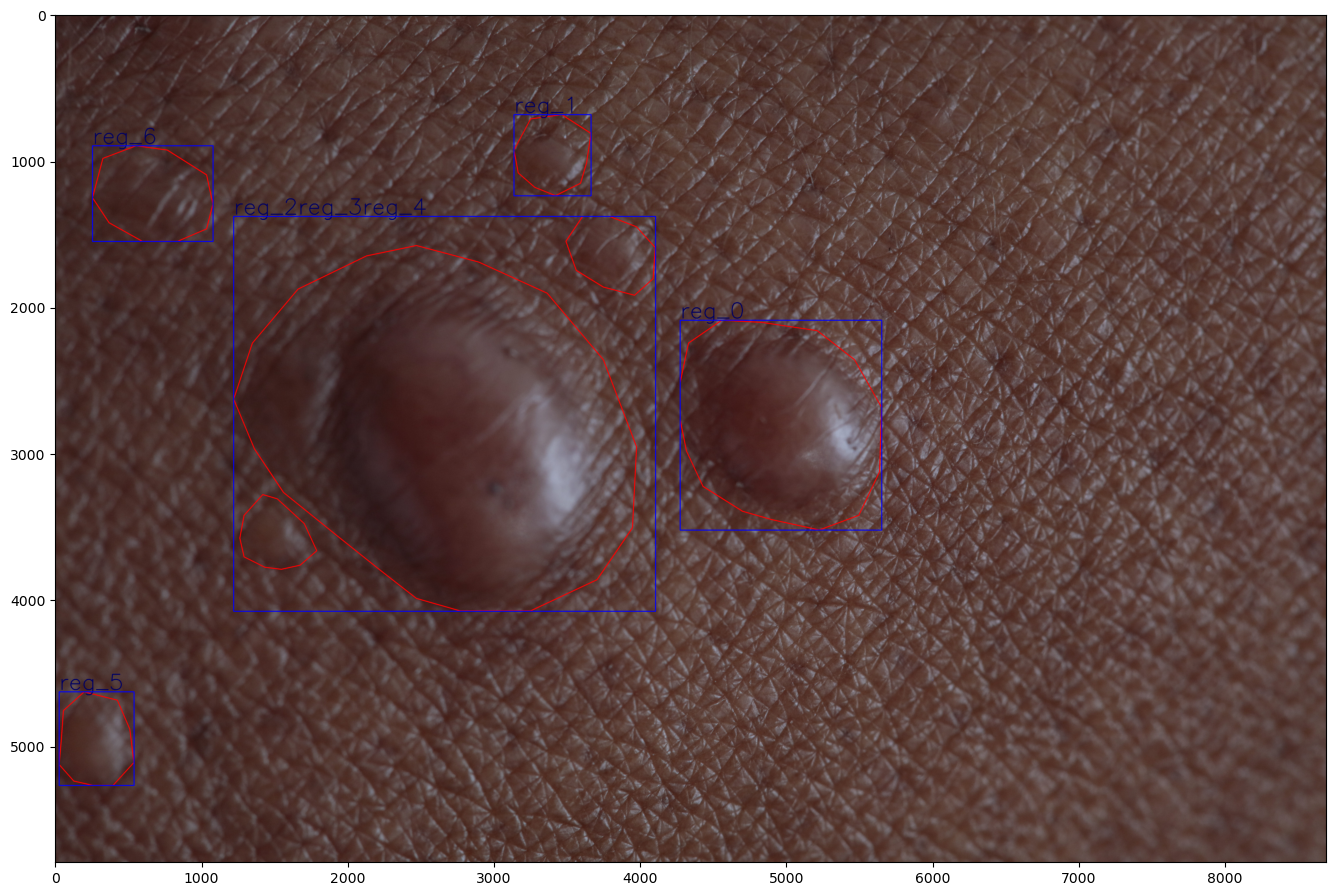

In [70]:
plt.figure(figsize=(18,11))
plt.imshow(image_to_drawn_2)

In [71]:
image_to_drawn_3 = image_to_drawn.copy()
expand = 100
for key in dict_contours:
    print(dict_contours[key])
    
    
    
    # x
    x  = dict_contours[key][0] - expand if (dict_contours[key][0] >= expand) else 0
    # y
    y = dict_contours[key][1] - expand if (dict_contours[key][1] >= expand) else 0
    # w
    w = dict_contours[key][2] + expand * 2 if (dict_contours[key][0] + dict_contours[key][2] + expand <= image_to_drawn_3.shape[1]) else image_to_drawn_3.shape[1] - dict_contours[key][0] + dict_contours[key][2]
    # h
    h = dict_contours[key][3] + expand * 2 if (dict_contours[key][1] + dict_contours[key][3] + expand <= image_to_drawn_3.shape[0]) else image_to_drawn_3.shape[0] - dict_contours[key][1] + dict_contours[key][3]
    print([x, y, w, h])
    
    image_to_drawn_3 = cv2.rectangle(image_to_drawn_3, (x, y), (x + w, y + h), color_ret, thickness)
    
    image_to_drawn_3 = cv2.putText(image_to_drawn_3, key, (x, y - 15), font, fontScale, color_text, thickness, cv2.LINE_AA)
    
    # print(new_box)

[4273, 2087, 1378, 1435]
[4173, 1987, 1578, 1635]
[3137, 681, 527, 555]
[3037, 581, 727, 755]
[28, 4628, 512, 640]
[0, 4528, 712, 840]
[256, 894, 824, 654]
[156, 794, 1024, 854]
[1221, 1377, 2884, 2700]
[1121, 1277, 3084, 2900]


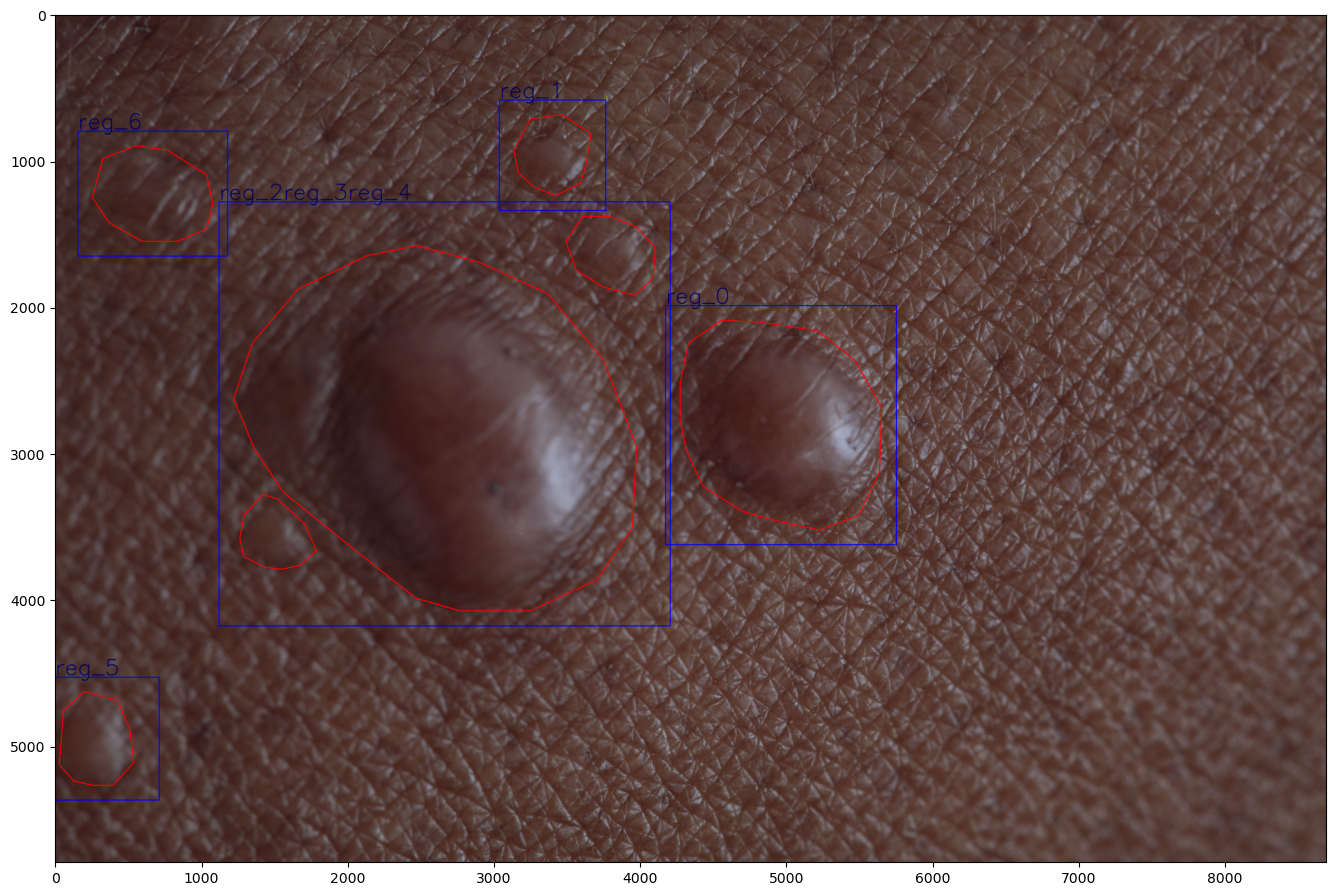

In [72]:
plt.figure(figsize=(18,11))
plt.imshow(image_to_drawn_3)

In [63]:
image_to_drawn_3.shape

(5792, 8688, 3)